In [1]:
import deeplake

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch

from models.simplepose import SimplePose
from models.datasets.lsp import LSPet, LSP

import numpy as np
from vis import show_pose

from torch.utils.tensorboard import SummaryWriter

In [2]:
# Load data
batch_size = 10  # Кол-во записей в пакете, передаваемом нейросети за раз
image_size = (128, 128)  # Размер входного изображения
# hmap_size = 32

tform = transforms.Compose([  # Объявление трансформации для исходных изображений:
    transforms.ToPILImage(),
    transforms.Resize(image_size),  # Рескейл изображений до заданного размера
    transforms.ToTensor(),  # Приведения исходного изображения к формату тензора
    # transforms.Normalize([0.5], [0.5]),
])

# lsp = LSPet('./models/datasets/lspet_dataset/', transform, image_size)
# lsp_loader = DataLoader(lsp, batch_size, shuffle=True, num_workers=1)

dl_train = deeplake.load("hub://activeloop/lsp-train")  # Получение данных
# Создание объекта, позволяющего итерировать данные
lsp_train_loader = dl_train.pytorch(
    tensors=["images", "keypoints"],
    decode_method={'images': 'numpy'},
    transform={'images': tform, 'keypoints': None},
    batch_size=batch_size, shuffle=True, num_workers=3
)

hub://activeloop/lsp-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-train


In [3]:
class MSELoss(torch.nn.Module):  # Лосс-функция средний квадрат ошибок

    def __init__(self):
        super(MSELoss, self).__init__()

    def forward(self, output, joints):
        output = output.view(output.shape[0], 14, 2)
        joints = joints[:, :, :-1]
        return torch.sum((output - joints) ** 2)

In [4]:
# Initialize the model
model = SimplePose().cuda()  # Инициализация модели и её выгрузка на ГПУ
model.load_state_dict(torch.load('./weights/simplepose9.weights'))  # Загрузка pre-trained weights
criterion = MSELoss().cuda()  # Инициализация объекта лосс-функции и его выгрузка на ГПУ
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Инициализация оптимизатора

In [5]:
# # Add network into tensorboard
# data = next(iter(lsp_train_loader))
#
# # Создание тензорборда
# tb = SummaryWriter()
# tb.add_graph(model, data[0].cuda())
# # tb.close()

In [6]:
# Train the model
for epoch in range(1):
    for batch, batch_data in enumerate(lsp_train_loader):

        model.zero_grad()

        input_image = batch_data['images'].cuda()
        joints_hmap = batch_data['keypoints'].cuda()
        # mask = batch_data[3].cuda()

        prediction = model(input_image)

        loss = criterion(prediction, joints_hmap)
        loss.backward()
        optimizer.step()

        # # Tensorboard
        # tb.add_scalar('Loss', loss, 1250*epoch + batch)

        if batch % 10 == 0:
            print('Batch: {}, Loss: {}, Epoch: {}'.format(batch, loss.data, epoch))
            # Add keypoints loss of testing data

    # # Tensorboard
    # for name, weight in model.named_parameters():
    #     tb.add_histogram(name, weight, epoch)
    #     tb.add_histogram(f'{name}.grad', weight.grad, epoch)

    torch.cuda.empty_cache()
    torch.save(model.state_dict(), './weights/simplepose{}.weights'.format(epoch))

# tb.close()

Please wait, filling up the shuffle buffer with samples.:   3%|▎         | 55.1M/1.91G [00:12<06:59, 4.74MB/s]   


Shuffle buffer filling is complete.
Batch: 0, Loss: 909493.8125, Epoch: 0
Batch: 10, Loss: 791956.75, Epoch: 0
Batch: 20, Loss: 714106.875, Epoch: 0
Batch: 30, Loss: 446182.0, Epoch: 0
Batch: 40, Loss: 550399.375, Epoch: 0
Batch: 50, Loss: 554523.8125, Epoch: 0
Batch: 60, Loss: 409422.5625, Epoch: 0
Batch: 70, Loss: 604665.6875, Epoch: 0
Batch: 80, Loss: 360482.0625, Epoch: 0
Batch: 90, Loss: 353916.625, Epoch: 0


hub://activeloop/lsp-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-test


Please wait, filling up the shuffle buffer with samples.:   3%|▎         | 55.7M/1.91G [00:12<06:56, 4.78MB/s]    


Shuffle buffer filling is complete.


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

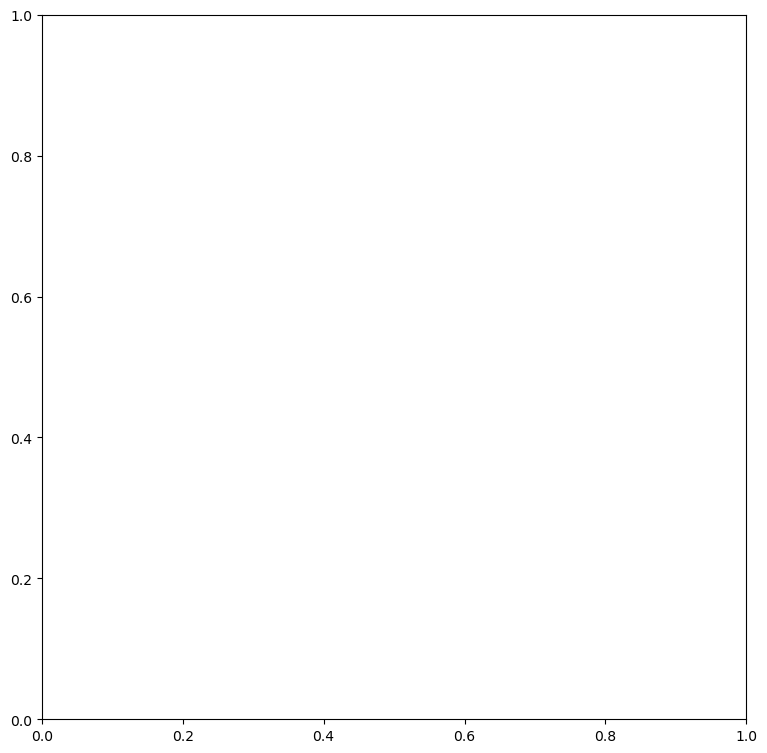

In [7]:
# lsp_test = LSP('./dataset/lsp_dataset/', transform, image_size)

dl_test = deeplake.load("hub://activeloop/lsp-test")
lsp_test_loader = dl_test.pytorch(
    tensors=["images", "keypoints"],
    decode_method={'images': 'numpy'},
    transform={'images': tform, 'keypoints': None},
    batch_size=batch_size, shuffle=True, num_workers=3
)
#
# test_image, *_ = lsp_test_loader.__getitem__(np.random.randint(len(lsp_test_loader)))
# test_image, *_ = lsp_test_loader[np.random.randint(len(lsp_test_loader))]
test_image, *_ = next(iter(lsp_test_loader))
test_predictions = model(test_image[0].cuda())
show_pose(test_image, test_predictions.squeeze().cpu().detach())